# Response Surface Methodology: Formulation Optimization

This notebook demonstrates a complete **Response Surface Methodology (RSM)** workflow
for optimizing a product formulation. We use a **Central Composite Design (CCD)**
to efficiently explore the factor space and find optimal operating conditions.

## Problem: Tablet Coating Formulation

We want to optimize a pharmaceutical tablet coating process with three factors:

| Factor | Name | Low | High | Units |
|--------|------|-----|------|-------|
| $x_1$ | Polymer concentration | 5 | 15 | % w/w |
| $x_2$ | Plasticizer level | 0.5 | 2.5 | % w/w |
| $x_3$ | Spray rate | 2 | 8 | mL/min |

**Response:** Film thickness uniformity score (0-100, higher is better)

## Workflow

1. **CCD Design** — Generate a Central Composite Design
2. **Run Experiments** — Collect response at each design point
3. **Fit Response Surface** — Quadratic polynomial model
4. **ANOVA** — Test significance of each term
5. **Diagnostics** — Residuals, parity, lack-of-fit
6. **Canonical Analysis** — Classify the stationary point
7. **Contour Plots** — Visualize the response surface
8. **Optimization** — Find the best operating conditions

In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

from jaxsr import ResponseSurface

np.random.seed(42)
print("Setup complete.")

Setup complete.


## Define the Problem

We set up the `ResponseSurface` object with our factor definitions.
This object manages design generation, fitting, ANOVA, canonical analysis,
and contour plotting.

In [ ]:
# Factor definitions
FACTOR_NAMES = ["polymer_conc", "plasticizer", "spray_rate"]
BOUNDS = [(5, 15), (0.5, 2.5), (2, 8)]  # Natural units
UNITS = ["% w/w", "% w/w", "mL/min"]

# Create ResponseSurface object
# CRITICAL for RSM: Use exhaustive search, not greedy
# Greedy forward selection can miss important quadratic terms when they are
# collinear with lower-order terms already in the model. Exhaustive search
# evaluates all possible subsets, ensuring the best quadratic model according
# to information criterion. For 3 factors, full quadratic has 10 terms
# (1 constant + 3 linear + 3 quadratic + 3 interactions), which is feasible.
rs = ResponseSurface(
    n_factors=3,
    bounds=BOUNDS,
    factor_names=FACTOR_NAMES,
    max_degree=2,              # Quadratic model (standard RSM)
    include_interactions=True,  # Include x_i * x_j terms
    strategy="exhaustive",     # Exhaustive search over all subsets
    max_terms=10,              # Allow full quadratic (1 + 3 + 3 + 3 = 10 terms)
)

print("Factor space:")
for name, bound, unit in zip(FACTOR_NAMES, BOUNDS, UNITS, strict=True):
    print(f"  {name:20s}: [{bound[0]}, {bound[1]}] {unit}")

## Step 1: Generate the CCD

A **Central Composite Design** combines:
- $2^k$ factorial points (corners of the cube)
- $2k$ axial (star) points (along each axis)
- $n_c$ center point replicates (for estimating pure error)

For 3 factors with 3 center points: $8 + 6 + 3 = 17$ runs.

In [3]:
# Generate CCD in natural units
X_design = rs.ccd(alpha="rotatable", center_points=3)

print(f"CCD Design: {len(X_design)} runs")
print(f"  Factorial points: {2**3} (cube corners)")
print(f"  Axial points: {2*3} (star points)")
print("  Center points: 3 (replicates)")
print()

# Display the design
print(f"  {'Run':>4}  {'polymer_conc':>12}  {'plasticizer':>12}  {'spray_rate':>11}")
print("  " + "-" * 46)
for i in range(len(X_design)):
    print(f"  {i+1:4d}  {X_design[i, 0]:12.2f}  {X_design[i, 1]:12.2f}  {X_design[i, 2]:11.2f}")

CCD Design: 17 runs
  Factorial points: 8 (cube corners)
  Axial points: 6 (star points)
  Center points: 3 (replicates)

   Run  polymer_conc   plasticizer   spray_rate
  ----------------------------------------------
     1          5.00          0.50         2.00
     2          5.00          0.50         8.00
     3          5.00          2.50         2.00
     4          5.00          2.50         8.00
     5         15.00          0.50         2.00
     6         15.00          0.50         8.00
     7         15.00          2.50         2.00
     8         15.00          2.50         8.00
     9         18.41          1.50         5.00
    10          1.59          1.50         5.00
    11         10.00          3.18         5.00
    12         10.00         -0.18         5.00
    13         10.00          1.50        10.05
    14         10.00          1.50        -0.05
    15         10.00          1.50         5.00
    16         10.00          1.50         5.00
    17       

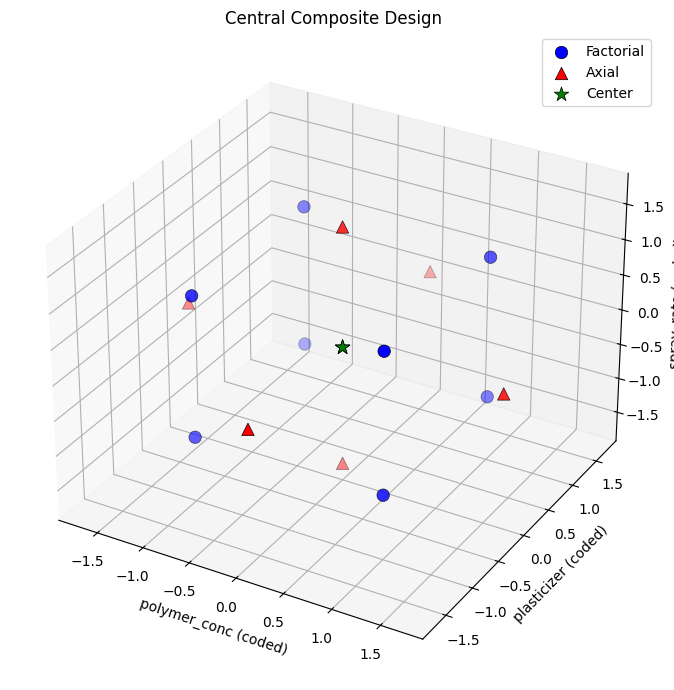

In [4]:
# Visualize the design in 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

# Convert to coded variables for visualization
X_coded = rs.encode(X_design)

# Color by point type
n_factorial = 2**3
n_axial = 2 * 3
n_center = 3

ax.scatter(X_coded[:n_factorial, 0], X_coded[:n_factorial, 1], X_coded[:n_factorial, 2],
           c="blue", s=80, label="Factorial", edgecolors="black", linewidth=0.5)
ax.scatter(X_coded[n_factorial:n_factorial+n_axial, 0],
           X_coded[n_factorial:n_factorial+n_axial, 1],
           X_coded[n_factorial:n_factorial+n_axial, 2],
           c="red", s=80, marker="^", label="Axial", edgecolors="black", linewidth=0.5)
ax.scatter(X_coded[n_factorial+n_axial:, 0],
           X_coded[n_factorial+n_axial:, 1],
           X_coded[n_factorial+n_axial:, 2],
           c="green", s=120, marker="*", label="Center", edgecolors="black", linewidth=0.5)

ax.set_xlabel("polymer_conc (coded)")
ax.set_ylabel("plasticizer (coded)")
ax.set_zlabel("spray_rate (coded)")
ax.set_title("Central Composite Design")
ax.legend()
plt.tight_layout()
plt.show()

## Step 2: Run Experiments

In a real study, you would run the experiments in the lab and record the response.
Here we simulate a response surface with a known quadratic model:

$$y = 80 + 5x_1 + 3x_2 - 2x_3 - 4x_1^2 - 3x_2^2 - 2x_3^2 + 2x_1 x_2 - x_1 x_3 + \varepsilon$$

In [5]:
def simulate_response(X):
    """Simulate the tablet coating process.

    Replace this function with actual experimental measurements.
    The response is a uniformity score (0-100).
    """
    # Work in coded variables for a clean quadratic model
    Xc = np.zeros_like(X)
    for j in range(X.shape[1]):
        lo, hi = BOUNDS[j]
        Xc[:, j] = 2 * (X[:, j] - lo) / (hi - lo) - 1  # encode to [-1, 1]

    x1, x2, x3 = Xc[:, 0], Xc[:, 1], Xc[:, 2]

    # True response surface (unknown to experimenter)
    y = (
        80
        + 5 * x1 + 3 * x2 - 2 * x3
        - 4 * x1**2 - 3 * x2**2 - 2 * x3**2
        + 2 * x1 * x2 - 1 * x1 * x3
    )
    noise = np.random.randn(len(y)) * 1.5  # Measurement noise
    return y + noise


# Run experiments
y_obs = simulate_response(X_design)

print(f"Collected {len(y_obs)} observations")
print(f"Response range: [{y_obs.min():.1f}, {y_obs.max():.1f}]")
print(f"Mean response: {y_obs.mean():.1f}")
print(f"Response std: {y_obs.std():.1f}")

Collected 17 observations
Response range: [61.1, 86.4]
Mean response: 72.6
Response std: 6.5


## Step 3: Fit the Response Surface Model

The `ResponseSurface` object automatically builds a quadratic basis library
(constant + linear + quadratic + interactions) and fits using symbolic regression.

JAXSR may discover that some quadratic or interaction terms are not needed —
giving you a simpler model than the full quadratic.

In [ ]:
# Fit the response surface
rs.fit(X_design, y_obs)

model = rs.model
print(model.summary())
print(f"\nExpression: {model.expression_}")
print(f"R²: {model.metrics_['r2']:.6f}")
print(f"MSE: {model.metrics_['mse']:.6g}")
print(f"Estimated noise (sigma): {model.sigma_:.4f}")

## Step 4: ANOVA

ANOVA tests the statistical significance of each model term.
Terms with large F-values (small p-values) are statistically significant.

In [ ]:
# Run ANOVA
anova_result = rs.anova(anova_type="sequential")

print("ANOVA Table (Type I — Sequential)")
print("=" * 85)
print(f"  {'Source':22s}  {'DF':>4}  {'Sum Sq':>10}  {'Mean Sq':>10}  {'F-value':>10}  {'p-value':>10}  {'Sig':>3}")
print("-" * 85)

summary_sources = {"Model", "Residual", "Total"}
for row in anova_result.rows:
    f_str = f"{row.f_value:10.2f}" if row.f_value is not None else "          "
    p_str = f"{row.p_value:10.4f}" if row.p_value is not None else "          "

    # Significance stars
    if row.p_value is not None:
        sig = "***" if row.p_value < 0.001 else ("**" if row.p_value < 0.01 else (
            "*" if row.p_value < 0.05 else ""))
    else:
        sig = ""

    prefix = "  " if row.source not in summary_sources else "> "
    print(f"{prefix}{row.source:22s}  {row.df:4d}  {row.sum_sq:10.2f}  {row.mean_sq:10.2f}  {f_str}  {p_str}  {sig:>3}")

    if row.source == "Total":
        break

print("-" * 85)
print("Significance: *** p<0.001, ** p<0.01, * p<0.05")

In [ ]:
# Visualize ANOVA — F-values for significant terms
term_rows = [r for r in anova_result.rows if r.source not in summary_sources and r.f_value is not None]

names = [r.source for r in term_rows]
f_values = [r.f_value for r in term_rows]
p_values = [r.p_value for r in term_rows]
colors = ["#4CAF50" if p < 0.05 else "#BDBDBD" for p in p_values]

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.barh(names, f_values, color=colors, edgecolor="black", linewidth=0.5)

# Add p-value annotations
for bar, p in zip(bars, p_values, strict=False):
    sig = "***" if p < 0.001 else ("**" if p < 0.01 else ("*" if p < 0.05 else "ns"))
    ax.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2,
            f"p={p:.4f} {sig}", va="center", fontsize=9)

ax.set_xlabel("F-value", fontsize=12)
ax.set_title("ANOVA: Term Significance (green = significant at p<0.05)", fontsize=13)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

## Step 5: Diagnostic Plots

Check model assumptions: normality, constant variance, no patterns in residuals.

In [ ]:
# Predictions and residuals
y_pred = np.asarray(model.predict(jnp.array(X_design)))
residuals = y_obs - y_pred
std_residuals = residuals / residuals.std()

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Parity plot (predicted vs actual)
ax = axes[0, 0]
ax.scatter(y_obs, y_pred, color="blue", s=50, edgecolors="black", linewidth=0.5)
lims = [min(y_obs.min(), y_pred.min()) - 2, max(y_obs.max(), y_pred.max()) + 2]
ax.plot(lims, lims, "r--", alpha=0.5, linewidth=1.5)
ax.set_xlabel("Observed", fontsize=11)
ax.set_ylabel("Predicted", fontsize=11)
ax.set_title(f"Parity Plot (R² = {model.metrics_['r2']:.4f})", fontsize=12)
ax.set_aspect("equal")

# 2. Residuals vs predicted
ax = axes[0, 1]
ax.scatter(y_pred, residuals, color="blue", s=50, edgecolors="black", linewidth=0.5)
ax.axhline(y=0, color="r", linestyle="--", alpha=0.5)
ax.set_xlabel("Predicted", fontsize=11)
ax.set_ylabel("Residual", fontsize=11)
ax.set_title("Residuals vs Predicted", fontsize=12)

# 3. Normal probability plot (Q-Q)
from scipy.special import erfinv

ax = axes[1, 0]
sorted_res = np.sort(std_residuals)
n = len(sorted_res)
theoretical = np.array([np.sqrt(2) * erfinv(2 * (i + 0.5) / n - 1) for i in range(n)])
ax.scatter(theoretical, sorted_res, color="blue", s=50, edgecolors="black", linewidth=0.5)
qq_lim = max(abs(theoretical.min()), abs(theoretical.max()), abs(sorted_res.min()), abs(sorted_res.max()))
ax.plot([-qq_lim, qq_lim], [-qq_lim, qq_lim], "r--", alpha=0.5)
ax.set_xlabel("Theoretical Quantiles", fontsize=11)
ax.set_ylabel("Standardized Residuals", fontsize=11)
ax.set_title("Normal Q-Q Plot", fontsize=12)

# 4. Residuals vs run order
ax = axes[1, 1]
ax.scatter(range(1, len(residuals) + 1), residuals, color="blue", s=50,
           edgecolors="black", linewidth=0.5)
ax.axhline(y=0, color="r", linestyle="--", alpha=0.5)
ax.set_xlabel("Run Order", fontsize=11)
ax.set_ylabel("Residual", fontsize=11)
ax.set_title("Residuals vs Run Order", fontsize=12)

plt.suptitle("Model Diagnostics", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

print("Residual statistics:")
print(f"  Mean: {residuals.mean():.4f} (should be ~0)")
print(f"  Std:  {residuals.std():.4f}")
print(f"  Max |residual|: {np.abs(residuals).max():.4f}")

## Step 6: Canonical Analysis

Canonical analysis finds the **stationary point** of the quadratic surface and
classifies it as a maximum, minimum, or saddle point.

- All eigenvalues negative → **maximum** (ideal for maximizing response)
- All eigenvalues positive → **minimum**
- Mixed signs → **saddle point** (ridge system)

In [ ]:
# Canonical analysis
ca = rs.canonical()

# Compute center of bounds as fallback if stationary point contains NaN
center_of_bounds = np.array([(lo + hi) / 2 for lo, hi in BOUNDS])
sp = ca.stationary_point
has_nan = np.any(np.isnan(sp))

if has_nan:
    print("WARNING: Stationary point contains NaN (model may lack quadratic terms).")
    print("Falling back to center of bounds for subsequent analysis.\n")
    sp = center_of_bounds

print("Canonical Analysis")
print("=" * 60)
print("\nStationary point (natural units):")
for name, val, (lo, hi), unit in zip(FACTOR_NAMES, sp, BOUNDS, UNITS, strict=True):
    in_range = "  (in range)" if lo <= val <= hi else "  *** OUT OF RANGE ***"
    print(f"  {name:20s} = {val:8.3f} {unit}{in_range}")

sp_response = ca.stationary_response
if has_nan:
    # Predict at center of bounds instead
    sp_response = float(model.predict(jnp.array([sp]))[0])
    print(f"\nPredicted response at center of bounds: {sp_response:.2f}")
else:
    print(f"\nPredicted response at stationary point: {sp_response:.2f}")

print(f"Nature: {ca.nature}")

print(f"\nEigenvalues: {ca.eigenvalues}")

print("\n" + "="*60)
print("Eigenvalue Interpretation (Pedagogical Note)")
print("="*60)
print("""
Eigenvalues are the PRINCIPAL CURVATURES of the quadratic response surface.

At the stationary point, the Hessian matrix (matrix of 2nd derivatives with
respect to all factors) determines how the surface curves in all directions.

• All λ < 0 → surface curves DOWNWARD in all directions → MAXIMUM
• All λ > 0 → surface curves UPWARD in all directions → MINIMUM  
• Mixed signs → surface curves UP in some directions, DOWN in others → SADDLE

For optimization:
  - MAXIMUM: stationary point is optimal formulation (desired for maximization)
  - MINIMUM: stationary point is worst formulation (explore boundaries)
  - SADDLE: ridge system - optimize along ridge directions (eigenvectors with λ≈0)
""")
print("="*60)

print("\nClassification:")
if all(e < 0 for e in ca.eigenvalues):
    print("  All eigenvalues negative → MAXIMUM")
    print("  The stationary point is the optimal formulation.")
elif all(e > 0 for e in ca.eigenvalues):
    print("  All eigenvalues positive → MINIMUM")
else:
    print("  Mixed eigenvalues → SADDLE POINT")
    print("  Consider exploring along the ridge.")

In [ ]:
#
 
P
r
e
d
i
c
t
 
a
t
 
t
h
e
 
s
t
a
t
i
o
n
a
r
y
 
p
o
i
n
t
 
(
o
r
 
c
e
n
t
e
r
 
o
f
 
b
o
u
n
d
s
 
i
f
 
N
a
N
)
 
w
i
t
h
 
u
n
c
e
r
t
a
i
n
t
y

X
_
o
p
t
 
=
 
n
p
.
a
r
r
a
y
(
[
s
p
]
)

y
_
o
p
t
,
 
o
p
t
_
l
o
,
 
o
p
t
_
h
i
 
=
 
m
o
d
e
l
.
p
r
e
d
i
c
t
_
i
n
t
e
r
v
a
l
(
j
n
p
.
a
r
r
a
y
(
X
_
o
p
t
)
,
 
a
l
p
h
a
=
0
.
0
5
)


p
r
i
n
t
(
"
P
r
e
d
i
c
t
i
o
n
 
a
t
 
o
p
t
i
m
u
m
:
"
)

p
r
i
n
t
(
f
"
 
 
U
n
i
f
o
r
m
i
t
y
 
s
c
o
r
e
 
=
 
{
f
l
o
a
t
(
y
_
o
p
t
[
0
]
)
:
.
2
f
}
"
)

p
r
i
n
t
(
f
"
 
 
9
5
%
 
P
I
:
 
[
{
f
l
o
a
t
(
o
p
t
_
l
o
[
0
]
)
:
.
2
f
}
,
 
{
f
l
o
a
t
(
o
p
t
_
h
i
[
0
]
)
:
.
2
f
}
]
"
)


#
 
C
o
e
f
f
i
c
i
e
n
t
 
s
i
g
n
i
f
i
c
a
n
c
e
 
w
i
t
h
 
t
-
s
t
a
t
i
s
t
i
c
s
 
a
n
d
 
p
-
v
a
l
u
e
s

f
r
o
m
 
s
c
i
p
y
 
i
m
p
o
r
t
 
s
t
a
t
s
 
a
s
 
s
p
_
s
t
a
t
s


p
r
i
n
t
(
"
\
n
C
o
e
f
f
i
c
i
e
n
t
 
S
i
g
n
i
f
i
c
a
n
c
e
 
(
9
5
%
 
C
I
)
:
"
)

i
n
t
e
r
v
a
l
s
 
=
 
m
o
d
e
l
.
c
o
e
f
f
i
c
i
e
n
t
_
i
n
t
e
r
v
a
l
s
(
a
l
p
h
a
=
0
.
0
5
)

n
,
 
k
 
=
 
l
e
n
(
y
_
o
b
s
)
,
 
l
e
n
(
m
o
d
e
l
.
s
e
l
e
c
t
e
d
_
f
e
a
t
u
r
e
s
_
)

d
f
 
=
 
n
 
-
 
k


p
r
i
n
t
(
f
"
 
 
{
'
T
e
r
m
'
:
>
2
5
s
}
 
{
'
E
s
t
i
m
a
t
e
'
:
>
1
0
s
}
 
{
'
S
t
d
 
E
r
r
'
:
>
9
s
}
 
{
'
t
'
:
>
8
s
}
 
{
'
p
-
v
a
l
u
e
'
:
>
1
0
s
}
 
9
5
%
 
C
I
"
)

p
r
i
n
t
(
"
 
 
"
 
+
 
"
-
"
 
*
 
8
5
)

f
o
r
 
n
a
m
e
,
 
(
e
s
t
,
 
l
o
,
 
h
i
,
 
s
e
)
 
i
n
 
i
n
t
e
r
v
a
l
s
.
i
t
e
m
s
(
)
:

 
 
 
 
t
_
v
a
l
 
=
 
e
s
t
 
/
 
s
e
 
i
f
 
a
b
s
(
s
e
)
 
>
 
1
e
-
1
5
 
e
l
s
e
 
f
l
o
a
t
(
"
i
n
f
"
)

 
 
 
 
p
_
v
a
l
 
=
 
f
l
o
a
t
(
2
 
*
 
(
1
 
-
 
s
p
_
s
t
a
t
s
.
t
.
c
d
f
(
a
b
s
(
t
_
v
a
l
)
,
 
d
f
)
)
)
 
i
f
 
d
f
 
>
 
0
 
e
l
s
e
 
0
.
0

 
 
 
 
s
i
g
 
=
 
"
*
*
*
"
 
i
f
 
p
_
v
a
l
 
<
 
0
.
0
0
1
 
e
l
s
e
 
(
"
*
*
"
 
i
f
 
p
_
v
a
l
 
<
 
0
.
0
1
 
e
l
s
e
 
(
"
*
"
 
i
f
 
p
_
v
a
l
 
<
 
0
.
0
5
 
e
l
s
e
 
"
"
)
)

 
 
 
 
p
r
i
n
t
(
f
"
 
 
{
n
a
m
e
:
>
2
5
s
}
 
{
e
s
t
:
1
0
.
4
f
}
 
{
s
e
:
9
.
4
f
}
 
{
t
_
v
a
l
:
8
.
2
f
}
 
{
p
_
v
a
l
:
1
0
.
2
e
}
 
[
{
l
o
:
.
4
f
}
,
 
{
h
i
:
.
4
f
}
]
 
{
s
i
g
}
"
)

p
r
i
n
t
(
"
 
 
-
-
-
 
*
*
*
 
p
<
0
.
0
0
1
,
 
*
*
 
p
<
0
.
0
1
,
 
*
 
p
<
0
.
0
5
"
)

## Step 7: Contour Plots

Visualize the response surface by holding one factor at its optimal value
and plotting contours for the other two factors.

In [ ]:
f
i
g
,
 
a
x
e
s
 
=
 
p
l
t
.
s
u
b
p
l
o
t
s
(
1
,
 
3
,
 
f
i
g
s
i
z
e
=
(
1
8
,
 
5
)
)


#
 
U
s
e
 
s
p
 
(
s
t
a
t
i
o
n
a
r
y
 
p
o
i
n
t
 
o
r
 
c
e
n
t
e
r
 
o
f
 
b
o
u
n
d
s
 
f
a
l
l
b
a
c
k
)
 
f
o
r
 
f
i
x
i
n
g
 
v
a
r
i
a
b
l
e
s


#
 
C
o
n
t
o
u
r
 
1
:
 
p
o
l
y
m
e
r
_
c
o
n
c
 
v
s
 
p
l
a
s
t
i
c
i
z
e
r
 
(
s
p
r
a
y
_
r
a
t
e
 
f
i
x
e
d
 
a
t
 
o
p
t
i
m
u
m
)

r
s
.
p
l
o
t
_
c
o
n
t
o
u
r
(

 
 
 
 
f
a
c
t
o
r
s
=
(
0
,
 
1
)
,

 
 
 
 
f
i
x
e
d
=
{
2
:
 
s
p
[
2
]
}
,

 
 
 
 
a
x
=
a
x
e
s
[
0
]
,

 
 
 
 
n
_
g
r
i
d
=
5
0
,

 
 
 
 
l
e
v
e
l
s
=
1
5
,

 
 
 
 
f
i
l
l
e
d
=
T
r
u
e
,

 
 
 
 
s
h
o
w
_
d
e
s
i
g
n
=
T
r
u
e
,

)

a
x
e
s
[
0
]
.
s
e
t
_
t
i
t
l
e
(
f
"
p
o
l
y
m
e
r
 
v
s
 
p
l
a
s
t
i
c
i
z
e
r
\
n
(
s
p
r
a
y
_
r
a
t
e
 
=
 
{
s
p
[
2
]
:
.
1
f
}
)
"
)


#
 
C
o
n
t
o
u
r
 
2
:
 
p
o
l
y
m
e
r
_
c
o
n
c
 
v
s
 
s
p
r
a
y
_
r
a
t
e
 
(
p
l
a
s
t
i
c
i
z
e
r
 
f
i
x
e
d
 
a
t
 
o
p
t
i
m
u
m
)

r
s
.
p
l
o
t
_
c
o
n
t
o
u
r
(

 
 
 
 
f
a
c
t
o
r
s
=
(
0
,
 
2
)
,

 
 
 
 
f
i
x
e
d
=
{
1
:
 
s
p
[
1
]
}
,

 
 
 
 
a
x
=
a
x
e
s
[
1
]
,

 
 
 
 
n
_
g
r
i
d
=
5
0
,

 
 
 
 
l
e
v
e
l
s
=
1
5
,

 
 
 
 
f
i
l
l
e
d
=
T
r
u
e
,

 
 
 
 
s
h
o
w
_
d
e
s
i
g
n
=
T
r
u
e
,

)

a
x
e
s
[
1
]
.
s
e
t
_
t
i
t
l
e
(
f
"
p
o
l
y
m
e
r
 
v
s
 
s
p
r
a
y
_
r
a
t
e
\
n
(
p
l
a
s
t
i
c
i
z
e
r
 
=
 
{
s
p
[
1
]
:
.
2
f
}
)
"
)


#
 
C
o
n
t
o
u
r
 
3
:
 
p
l
a
s
t
i
c
i
z
e
r
 
v
s
 
s
p
r
a
y
_
r
a
t
e
 
(
p
o
l
y
m
e
r
_
c
o
n
c
 
f
i
x
e
d
 
a
t
 
o
p
t
i
m
u
m
)

r
s
.
p
l
o
t
_
c
o
n
t
o
u
r
(

 
 
 
 
f
a
c
t
o
r
s
=
(
1
,
 
2
)
,

 
 
 
 
f
i
x
e
d
=
{
0
:
 
s
p
[
0
]
}
,

 
 
 
 
a
x
=
a
x
e
s
[
2
]
,

 
 
 
 
n
_
g
r
i
d
=
5
0
,

 
 
 
 
l
e
v
e
l
s
=
1
5
,

 
 
 
 
f
i
l
l
e
d
=
T
r
u
e
,

 
 
 
 
s
h
o
w
_
d
e
s
i
g
n
=
T
r
u
e
,

)

a
x
e
s
[
2
]
.
s
e
t
_
t
i
t
l
e
(
f
"
p
l
a
s
t
i
c
i
z
e
r
 
v
s
 
s
p
r
a
y
_
r
a
t
e
\
n
(
p
o
l
y
m
e
r
_
c
o
n
c
 
=
 
{
s
p
[
0
]
:
.
1
f
}
)
"
)


p
l
t
.
s
u
p
t
i
t
l
e
(
"
R
e
s
p
o
n
s
e
 
S
u
r
f
a
c
e
 
C
o
n
t
o
u
r
 
P
l
o
t
s
"
,
 
f
o
n
t
s
i
z
e
=
1
4
,
 
f
o
n
t
w
e
i
g
h
t
=
"
b
o
l
d
"
)

p
l
t
.
t
i
g
h
t
_
l
a
y
o
u
t
(
)

p
l
t
.
s
h
o
w
(
)

## Step 8: Perturbation Analysis

Show how each factor affects the response when varied from the center point
while holding other factors at their center values.

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

center = np.array([(lo + hi) / 2 for lo, hi in BOUNDS])
colors = ["#2196F3", "#FF9800", "#4CAF50"]

for j, (name, color) in enumerate(zip(FACTOR_NAMES, colors, strict=False)):
    lo, hi = BOUNDS[j]
    x_range = np.linspace(lo, hi, 50)

    # Vary factor j, hold others at center
    X_sweep = np.tile(center, (50, 1))
    X_sweep[:, j] = x_range

    y_sweep = np.asarray(model.predict(jnp.array(X_sweep)))

    # Normalize x-axis to coded units for comparison
    x_coded = 2 * (x_range - lo) / (hi - lo) - 1

    ax.plot(x_coded, y_sweep, color=color, linewidth=2, label=name)

ax.set_xlabel("Factor Level (coded units)", fontsize=12)
ax.set_ylabel("Predicted Response", fontsize=12)
ax.set_title("Perturbation Plot (other factors at center)", fontsize=13)
ax.axvline(x=0, color="gray", linestyle=":", alpha=0.5)
ax.legend(fontsize=11)
plt.tight_layout()
plt.show()

print("Steeper curves = factor has more influence on the response.")

## Step 9: Optimization Summary

In [ ]:
p
r
i
n
t
(
"
+
"
 
+
 
"
=
"
 
*
 
6
5
 
+
 
"
+
"
)

p
r
i
n
t
(
"
|
"
 
+
 
"
 
R
S
M
 
F
O
R
M
U
L
A
T
I
O
N
 
O
P
T
I
M
I
Z
A
T
I
O
N
 
-
-
 
F
I
N
A
L
 
R
E
P
O
R
T
"
.
c
e
n
t
e
r
(
6
5
)
 
+
 
"
|
"
)

p
r
i
n
t
(
"
|
"
 
+
 
"
=
"
 
*
 
6
5
 
+
 
"
|
"
)

p
r
i
n
t
(
"
|
"
 
+
 
"
 
M
o
d
e
l
 
S
u
m
m
a
r
y
"
.
c
e
n
t
e
r
(
6
5
)
 
+
 
"
|
"
)

p
r
i
n
t
(
"
|
"
 
+
 
"
-
"
 
*
 
6
5
 
+
 
"
|
"
)

p
r
i
n
t
(
f
"
|
 
 
E
x
p
r
e
s
s
i
o
n
:
 
{
m
o
d
e
l
.
e
x
p
r
e
s
s
i
o
n
_
}
"
)

p
r
i
n
t
(
f
"
|
 
 
R
2
 
=
 
{
m
o
d
e
l
.
m
e
t
r
i
c
s
_
[
'
r
2
'
]
:
.
6
f
}
"
)

p
r
i
n
t
(
f
"
|
 
 
M
S
E
 
=
 
{
m
o
d
e
l
.
m
e
t
r
i
c
s
_
[
'
m
s
e
'
]
:
.
4
f
}
"
)

p
r
i
n
t
(
f
"
|
 
 
T
e
r
m
s
 
=
 
{
l
e
n
(
m
o
d
e
l
.
s
e
l
e
c
t
e
d
_
f
e
a
t
u
r
e
s
_
)
}
"
)

p
r
i
n
t
(
"
|
"
 
+
 
"
=
"
 
*
 
6
5
 
+
 
"
|
"
)

p
r
i
n
t
(
"
|
"
 
+
 
"
 
O
p
t
i
m
a
l
 
F
o
r
m
u
l
a
t
i
o
n
"
.
c
e
n
t
e
r
(
6
5
)
 
+
 
"
|
"
)

p
r
i
n
t
(
"
|
"
 
+
 
"
-
"
 
*
 
6
5
 
+
 
"
|
"
)

i
f
 
h
a
s
_
n
a
n
:

 
 
 
 
p
r
i
n
t
(
"
|
 
 
N
O
T
E
:
 
S
t
a
t
i
o
n
a
r
y
 
p
o
i
n
t
 
w
a
s
 
N
a
N
;
 
u
s
i
n
g
 
c
e
n
t
e
r
 
o
f
 
b
o
u
n
d
s
.
"
)

f
o
r
 
n
a
m
e
,
 
v
a
l
,
 
u
n
i
t
 
i
n
 
z
i
p
(
F
A
C
T
O
R
_
N
A
M
E
S
,
 
s
p
,
 
U
N
I
T
S
,
 
s
t
r
i
c
t
=
T
r
u
e
)
:

 
 
 
 
p
r
i
n
t
(
f
"
|
 
 
{
n
a
m
e
:
2
0
s
}
 
=
 
{
v
a
l
:
8
.
3
f
}
 
{
u
n
i
t
}
"
)

p
r
i
n
t
(
"
|
"
)

p
r
i
n
t
(
f
"
|
 
 
P
r
e
d
i
c
t
e
d
 
u
n
i
f
o
r
m
i
t
y
 
=
 
{
f
l
o
a
t
(
y
_
o
p
t
[
0
]
)
:
.
1
f
}
"
)

p
r
i
n
t
(
f
"
|
 
 
9
5
%
 
P
I
:
 
[
{
f
l
o
a
t
(
o
p
t
_
l
o
[
0
]
)
:
.
1
f
}
,
 
{
f
l
o
a
t
(
o
p
t
_
h
i
[
0
]
)
:
.
1
f
}
]
"
)

p
r
i
n
t
(
f
"
|
 
 
S
t
a
t
i
o
n
a
r
y
 
p
o
i
n
t
:
 
{
c
a
.
n
a
t
u
r
e
}
"
)

p
r
i
n
t
(
"
|
"
 
+
 
"
=
"
 
*
 
6
5
 
+
 
"
|
"
)

p
r
i
n
t
(
"
|
"
 
+
 
"
 
L
a
T
e
X
"
.
c
e
n
t
e
r
(
6
5
)
 
+
 
"
|
"
)

p
r
i
n
t
(
"
|
"
 
+
 
"
-
"
 
*
 
6
5
 
+
 
"
|
"
)

p
r
i
n
t
(
f
"
|
 
 
$
{
m
o
d
e
l
.
t
o
_
l
a
t
e
x
(
)
}
$
"
)

p
r
i
n
t
(
"
+
"
 
+
 
"
=
"
 
*
 
6
5
 
+
 
"
+
"
)

In [ ]:
#
 
S
a
v
e
 
m
o
d
e
l
 
f
o
r
 
d
e
p
l
o
y
m
e
n
t

m
o
d
e
l
.
s
a
v
e
(
"
f
o
r
m
u
l
a
t
i
o
n
_
m
o
d
e
l
.
j
s
o
n
"
)


#
 
E
x
p
o
r
t
 
p
u
r
e
 
N
u
m
P
y
 
c
a
l
l
a
b
l
e

p
r
e
d
i
c
t
_
f
n
 
=
 
m
o
d
e
l
.
t
o
_
c
a
l
l
a
b
l
e
(
)


#
 
V
e
r
i
f
y
 
a
t
 
t
h
e
 
o
p
t
i
m
u
m
 
(
s
p
 
i
s
 
t
h
e
 
s
t
a
t
i
o
n
a
r
y
 
p
o
i
n
t
 
o
r
 
c
e
n
t
e
r
-
o
f
-
b
o
u
n
d
s
 
f
a
l
l
b
a
c
k
)

y
_
c
h
e
c
k
 
=
 
p
r
e
d
i
c
t
_
f
n
(
n
p
.
a
r
r
a
y
(
[
s
p
]
)
)

p
r
i
n
t
(
f
"
N
u
m
P
y
 
c
a
l
l
a
b
l
e
 
p
r
e
d
i
c
t
i
o
n
 
a
t
 
o
p
t
i
m
u
m
:
 
{
y
_
c
h
e
c
k
[
0
]
:
.
2
f
}
"
)


#
 
C
l
e
a
n
 
u
p

i
m
p
o
r
t
 
o
s


i
f
 
o
s
.
p
a
t
h
.
e
x
i
s
t
s
(
"
f
o
r
m
u
l
a
t
i
o
n
_
m
o
d
e
l
.
j
s
o
n
"
)
:

 
 
 
 
o
s
.
r
e
m
o
v
e
(
"
f
o
r
m
u
l
a
t
i
o
n
_
m
o
d
e
l
.
j
s
o
n
"
)

## Summary

This notebook demonstrated the complete RSM workflow for formulation optimization:

1. **CCD Design** — 17-run Central Composite Design with center replicates
2. **Quadratic Model** — Full second-order polynomial fitted via symbolic regression
3. **ANOVA** — Identified significant terms and their F-statistics
4. **Diagnostics** — Verified normality, constant variance, and independence
5. **Canonical Analysis** — Found the stationary point and classified it
6. **Contour Plots** — Visualized the response surface for all factor pairs
7. **Perturbation Analysis** — Compared factor sensitivities

### Key Design Choices

| Choice | Recommendation |
|--------|---------------|
| Design | CCD for quadratic models; Box-Behnken if corner points are infeasible |
| Center points | 3-5 replicates for pure error and lack-of-fit testing |
| Model | Start with full quadratic; JAXSR automatically removes insignificant terms |
| Analysis | Always check ANOVA, residuals, and canonical analysis before reporting |
| Stationary point | If outside bounds, report the best point on the boundary instead |